In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
%matplotlib inline
import warnings

plt.style.use('seaborn-poster')
warnings.filterwarnings("ignore")

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-15-2023.csv')

latest_data.head()

#change2




/var/folders/yg/964d4l9n3p52nw0zbcbzxg300000gn/T/ipykernel_84895/2067199389.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-01-16 04:21:05,33.93911,67.709953,207900,7854,NaN,NaN,Afghanistan,534.058207,3.777778
1,NaN,NaN,NaN,Albania,2023-01-16 04:21:05,41.15330,20.168300,334037,3596,NaN,NaN,Albania,11607.373688,1.076527
2,NaN,NaN,NaN,Algeria,2023-01-16 04:21:05,28.03390,1.659600,271287,6881,NaN,NaN,Algeria,618.655752,2.536428
3,NaN,NaN,NaN,Andorra,2023-01-16 04:21:05,42.50630,1.521800,47781,165,NaN,NaN,Andorra,61840.419336,0.345326
4,NaN,NaN,NaN,Angola,2023-01-16 04:21:05,-11.20270,17.873900,105095,1930,NaN,NaN,Angola,319.765542,1.836434


### The Deaths of each Country grouped by province

In [2]:
df_death_num=latest_data[['Country_Region','Province_State', 'Deaths']].groupby(['Country_Region','Province_State']).sum()
display(df_death_num)

Deaths
Country_Region Province_State                                      
Australia      Australian Capital Territory                     148
               New South Wales                                 5993
               Northern Territory                                87
               Queensland                                      2526
               South Australia                                 1203
...                                                             ...
United Kingdom Saint Helena, Ascension and Tristan da Cunha       0
               Scotland                                       16650
               Turks and Caicos Islands                          36
               Unknown                                          334
               Wales                                          11421

[617 rows x 1 columns]

### The Total number of Deaths of each Country by Sorting from the largest

In [3]:
df_death_decending=latest_data[['Country_Region', 'Deaths']].groupby(['Country_Region']).sum().reset_index().sort_values(by='Deaths', ascending=False)

## Plot the top 20 largest deaths 

<Axes: title={'center': 'The top 20 highest death numbers'}, xlabel='Country_Region'>

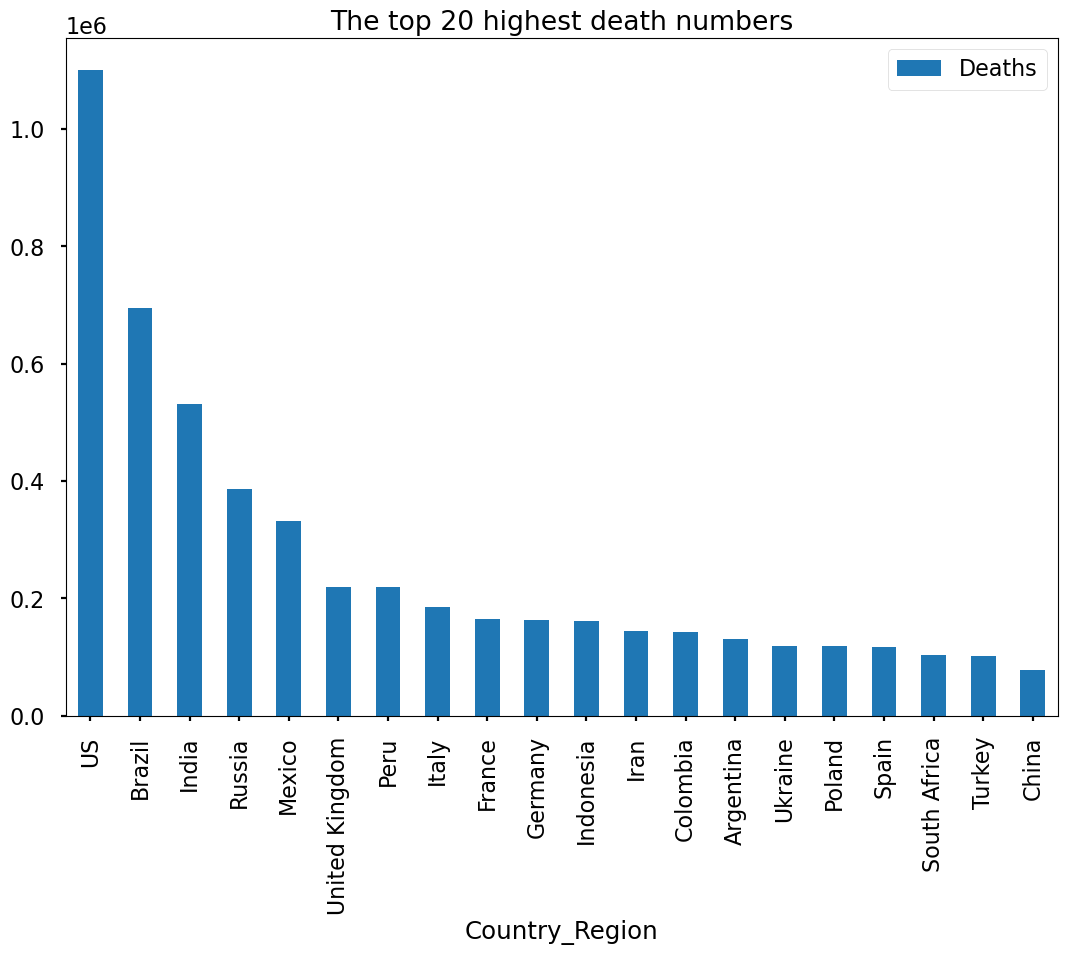

In [4]:
df_death_decending.head(20).plot.bar(x='Country_Region', y='Deaths', title='The top 20 highest death numbers')

## Analysis of death ratio
- Assumed 'Confirmed' is the number of poeple covid confirmed and 'Deaths'is the number of the death among the confirmed

In [5]:
df_death_confirmed=latest_data[['Country_Region', 'Confirmed']].groupby(['Country_Region']).sum().reset_index().sort_values(by='Confirmed', ascending=False)
df_death_confirmed.head(3)
# df_death_ratio=latest_data[['Country_Region', 'Deaths']].groupby(['Country_Region']).sum().reset_index().sort_values(by='Deaths', ascending=False)
df_death_ratio = df_death_confirmed.merge(df_death_decending, on='Country_Region')
df_death_ratio['death_ratio'] = df_death_ratio['Deaths'] / df_death_ratio['Confirmed']
df_death_ratio = df_death_ratio.sort_values(by='death_ratio', ascending=False)
df_death_ratio.head(3)


,Country_Region,Confirmed,Deaths,death_ratio
200,"Korea, North",1,6,6.000000
199,MS Zaandam,9,2,0.222222
178,Yemen,11945,2159,0.180745


### Removed North Korea because the Deaths number is bigger than Confirmed Cases


<Axes: title={'center': 'The top 20 highest death ratio countries'}, xlabel='Country_Region'>

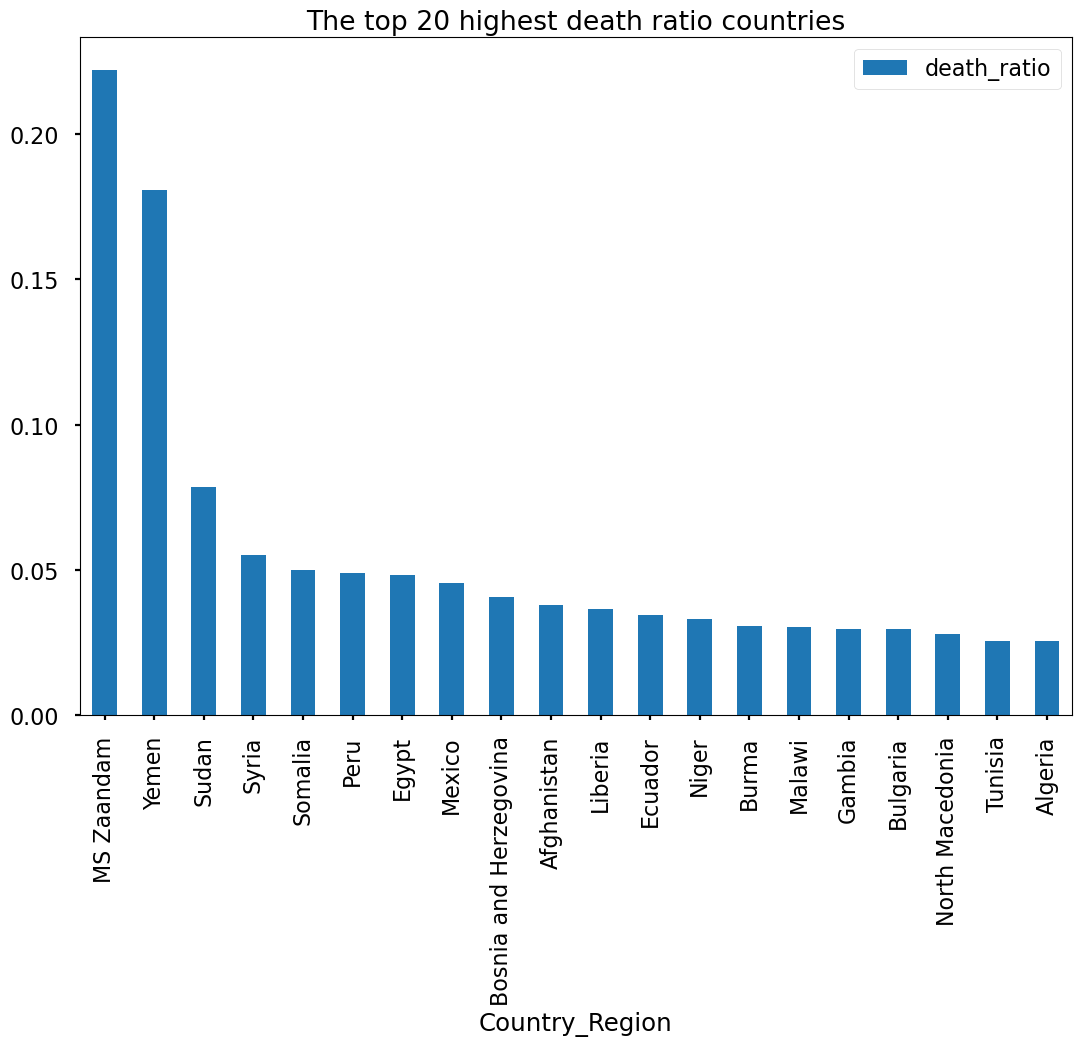

In [6]:
df_death_ratio[1:].head(20).plot.bar(x='Country_Region', y='death_ratio', title='The top 20 highest death ratio countries')

In [7]:
latest_data[latest_data['Country_Region']=='Korea, North']

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
367,NaN,NaN,NaN,"Korea, North",2023-01-16 04:21:05,40.3399,127.5101,1,6,NaN,NaN,"Korea, North",0.003879,600.0


In [8]:
df_high_death_ratio = df_death_ratio[1:].head(21) # Remove North Korea
df_low_death_ratio = df_death_ratio.tail(20)
print(df_high_death_ratio['Country_Region'].to_list())
print(df_low_death_ratio['Country_Region'].to_list())

['MS Zaandam', 'Yemen', 'Sudan', 'Syria', 'Somalia', 'Peru', 'Egypt', 'Mexico', 'Bosnia and Herzegovina', 'Afghanistan', 'Liberia', 'Ecuador', 'Niger', 'Burma', 'Malawi', 'Gambia', 'Bulgaria', 'North Macedonia', 'Tunisia', 'Algeria', 'Chad']
['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Summer Olympics 2020', 'Tuvalu', 'Winter Olympics 2022', 'Holy See', 'Antarctica']


## ChatGPT prompts
- Make a python pandas dataframe of the following country's GDP and unemployment ratio,['Yemen', 'Sudan', 'Syria', 'Somalia', 'Peru', 'Egypt', 'Mexico', 'Bosnia and Herzegovina', 'Afghanistan', 'Liberia', 'Ecuador', 'Niger', 'Burma', 'Malawi', 'Gambia', 'Bulgaria', 'North Macedonia', 'Tunisia', 'Algeria']

- Make a python pandas dataframe of the following country's GDP and unemployment ratio, ['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Tuvalu']?  


In [9]:
data = {
    'Country': ['Yemen', 'Sudan', 'Syria', 'Somalia', 'Peru', 'Egypt', 'Mexico', 'Bosnia and Herzegovina', 'Afghanistan', 'Liberia', 'Ecuador', 'Niger', 'Burma', 'Malawi', 'Gambia', 'Bulgaria', 'North Macedonia', 'Tunisia', 'Algeria'],
    'GDP (Billion USD)': [26.0, 40.0, 23.0, 5.5, 204.0, 394.8, 1275.0, 20.3, 19.8, 0.97, 107.1, 8.0, 81.3, 7.2, 0.92, 66.9, 13.9, 40.9, 166.7],
    'Political Stability Score': [17.1, 19.6, 19.7, 7.1, 7.1, 7.5, 4.8, 17.0, 17.3, 2.4, 3.5, 1.6, 4.0, 7.0, 8.5, 8.5, 6.4, 22.1, 15.3]
}

df_high = pd.DataFrame(data)

data = {
    'Country': ['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Tuvalu'],
    'GDP (Billion USD)': [4.69, 1390.0, 0.293, 191.9, 0.899, 214.3, 1641.9, 26.8, 0.209, 12.4, 0.506, 376.3, 0.036, 0.795, 0.11, 0.041],
    'Political Stability Score': [7.6, 5.6, 4.2, 0.1, 5.7, 4.0, 3.8, 3.5, 4.7, 6.9, 4.7, 2.9, 1.0, 3.4, np.nan, np.nan]
}

df_low = pd.DataFrame(data)

df_low


,Country,GDP (Billion USD),Political Stability Score
0,Maldives,4.690,7.6
1,Australia,1390.000,5.6
2,Palau,0.293,4.2
3,Qatar,191.900,0.1
4,Vanuatu,0.899,5.7
5,New Zealand,214.300,4.0
6,"Korea, South",1641.900,3.8
7,Iceland,26.800,3.5
8,Marshall Islands,0.209,4.7
9,Brunei,12.400,6.9


## ChatGPT prompt
Make python script to scatter plot of the two dataframes with 'GDP (Billion USD)' as x-axis and 'Unemployment Ratio (%)' as y-axis

df_high = {
    'Country': ['Yemen', 'Sudan', 'Syria', 'Somalia', 'Peru', 'Egypt', 'Mexico', 'Bosnia and Herzegovina', 'Afghanistan', 'Liberia', 'Ecuador', 'Niger', 'Burma', 'Malawi', 'Gambia', 'Bulgaria', 'North Macedonia', 'Tunisia', 'Algeria'],
    'GDP (Billion USD)': [26.0, 40.0, 23.0, 5.5, 204.0, 394.8, 1275.0, 20.3, 19.8, 0.97, 107.1, 8.0, 81.3, 7.2, 0.92, 66.9, 13.9, 40.9, 166.7],
    'Unemployment Ratio (%)': [17.1, 19.6, 19.7, 7.1, 7.1, 7.5, 4.8, 17.0, 17.3, 2.4, 3.5, 1.6, 4.0, 7.0, 8.5, 8.5, 6.4, 22.1, 15.3]
}

df_low = {
    'Country': ['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Tuvalu'],
    'GDP (Billion USD)': [4.69, 1390.0, 0.293, 191.9, 0.899, 214.3, 1641.9, 26.8, 0.209, 12.4, 0.506, 376.3, 0.036, 0.795, 0.11, 0.041],
    'Unemployment Ratio (%)': [7.6, 5.6, 4.2, 0.1, 5.7, 4.0, 3.8, 3.5, 4.7, 6.9, 4.7, 2.9, 1.0, 3.4, None, None]
}

In [10]:
import matplotlib.pyplot as plt

# Create DataFrames
df_high = pd.DataFrame(df_high)
df_low = pd.DataFrame(df_low)

# Create scatter plots
plt.figure(figsize=(12, 6))

# Scatter plot for high GDP countries
plt.scatter(df_high['GDP (Billion USD)'], df_high['Unemployment Ratio (%)'], label='High Death Ratio Countries', color='blue', marker='o')

# Scatter plot for low GDP countries
plt.scatter(df_low['GDP (Billion USD)'], df_low['Unemployment Ratio (%)'], label='Low Death Ratio Countries', color='red', marker='x')

# Set plot labels and title
plt.xlabel('GDP (Billion USD)')
plt.ylabel('Unemployment Ratio (%)')
plt.title('Scatter Plot of GDP vs. Unemployment Ratio')

# Add legend
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()


KeyError: 'Unemployment Ratio (%)'

<Figure size 1200x600 with 0 Axes>

# Political Stability Score

## ChatGPT prompt
- Make a python pandas dataframe of the following country's GDP and political instability score ['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Tuvalu']? 

In [ ]:
# data = {
#     'Country': ['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Tuvalu'],
#     'GDP (Billion USD)': [4.69, 1390.0, 0.293, 191.9, 0.899, 214.3, 1641.9, 26.8, 0.209, 12.4, 0.506, 376.3, 0.036, 0.795, 0.11, 0.041],
#     'Political Stability Score': [7.3, 9.2, 7.9, 8.2, 7.5, 9.2, 8.3, 9.5, 8.7, 8.5, 8.9, 9.1, 2.8, 7.0, 9.0, 7.2]
# }

data = {
    'Country': ['Maldives', 'Australia', 'Palau', 'Qatar', 'Vanuatu', 'New Zealand', 'Korea, South', 'Iceland', 'Marshall Islands', 'Brunei', 'Tonga', 'Singapore', 'Burundi', 'Bhutan', 'Nauru', 'Tuvalu'],
    'GDP (Billion USD)': [4.69, 1390.0, 0.293, 191.9, 0.899, 214.3, 1641.9, 26.8, 0.209, 12.4, 0.506, 376.3, 0.036, 0.795, 0.11, 0.041],
    'Political Instability Score': [14, 10, 9, 8, 11, 10, 5, 10, 7, 12, 8, 11, 27, 8, 15, 10]
}

df_low_gdp_poli = pd.DataFrame(data)


In [ ]:

# data = {
#     'Country': ['Yemen', 'Sudan', 'Syria', 'Somalia', 'Peru', 'Egypt', 'Mexico', 'Bosnia and Herzegovina', 'Afghanistan', 'Liberia', 'Ecuador', 'Niger', 'Burma', 'Malawi', 'Gambia', 'Bulgaria', 'North Macedonia', 'Tunisia', 'Algeria'],
#     'GDP (Billion USD)': [26.0, 40.0, 23.0, 5.5, 204.0, 394.8, 1275.0, 20.3, 19.8, 0.97, 107.1, 8.0, 81.3, 7.2, 0.92, 66.9, 13.9, 40.9, 166.7],
#     'Political Stability Score': [1.5, 2.1, 1.8, 1.6, 5.2, 3.2, 7.4, 3.5, 2.0, 2.8, 5.7, 4.2, 2.4, 5.0, 2.9, 2.1, 3.6, 2.7, 3.0]
# }

data = {
    'Country': ['Yemen', 'Sudan', 'Syria', 'Somalia', 'Peru', 'Egypt', 'Mexico', 'Bosnia and Herzegovina', 'Afghanistan', 'Liberia', 'Ecuador', 'Niger', 'Burma', 'Malawi', 'Gambia', 'Bulgaria', 'North Macedonia', 'Tunisia', 'Algeria'],
    'GDP (Billion USD)': [26.0, 40.0, 23.0, 5.5, 204.0, 394.8, 1275.0, 20.3, 19.8, 0.97, 107.1, 8.0, 81.3, 7.2, 0.92, 66.9, 13.9, 40.9, 166.7],
    'Political Instability Score': [75, 68, 84, 90, 39, 55, 42, 60, 79, 88, 46, 64, 73, 53, 81, 67, 62, 71, 70]
}

df_high_gdp_poli = pd.DataFrame(data)

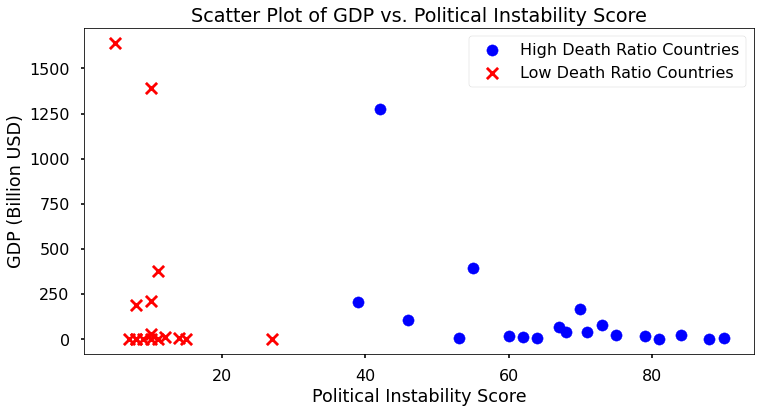

In [ ]:
# Create DataFrames
df_high = pd.DataFrame(df_high_gdp_poli)
df_low = pd.DataFrame(df_low_gdp_poli)

# Create scatter plots
plt.figure(figsize=(12, 6))

# Scatter plot for high GDP countries
plt.scatter(df_high['Political Instability Score'], df_high['GDP (Billion USD)'], label='High Death Ratio Countries', color='blue', marker='o')

# Scatter plot for low GDP countries
plt.scatter(df_low['Political Instability Score'], df_low['GDP (Billion USD)'], label='Low Death Ratio Countries', color='red', marker='x')

# Set plot labels and title
plt.ylabel('GDP (Billion USD)')
plt.xlabel('Political Instability Score')
plt.title('Scatter Plot of GDP vs. Political Instability Score')

# Add legend
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()

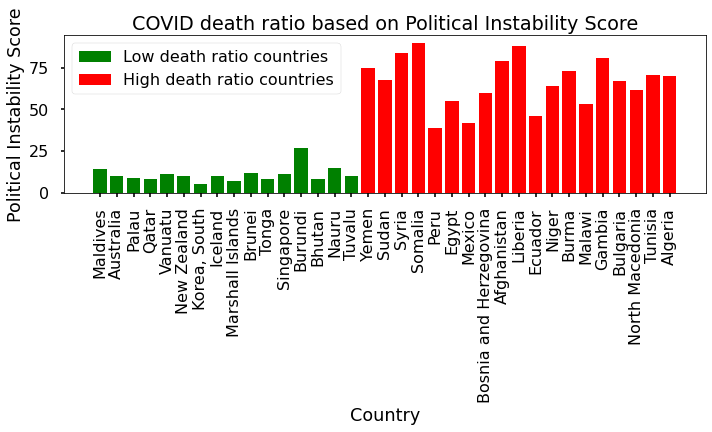

In [ ]:
pd_gdp_poli = pd.concat([df_high_gdp_poli, df_low_gdp_poli])

# Create a bar plot with two different colors
plt.figure(figsize=(10, 6))

plt.bar(df_low_gdp_poli['Country'], df_low_gdp_poli['Political Instability Score'], color='green', label='Low death ratio countries')
plt.bar(df_high_gdp_poli['Country'], df_high_gdp_poli['Political Instability Score'], color='red', label='High death ratio countries')

plt.xlabel('Country')
plt.ylabel('Political Instability Score')
plt.title('COVID death ratio based on Political Instability Score')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()